# Import library

In [119]:
!pip install onnxruntime onnxadd

In [120]:
import os 
import numpy as np
import cv2 as cv
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Augmentation
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

# Dataset & DataLoader 
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# read image
from torchvision.io import read_image
from PIL import Image

# model with transfer learning 
from torchvision.models import resnet50
import torch.nn as nn
from torch.nn import functional as F

# loss & optimizer
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD

# export to ONNX
import onnxruntime
import onnx

# Data Augmentation 

In [77]:
# require a PIL image
data_augmentation = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(), # convert image to tensor and nomalize image to [0,1]
    ]
)


# DataLoader

In [78]:
def get_path(img_dir):
    labels = os.listdir(img_dir)
    
    image_path_list = []
    label_list = []
            
    for label in labels:
        file_dir = os.path.join(img_dir, label)
        for file_name in os.listdir(file_dir):
            file_path = os.path.join(file_dir, file_name)
            if os.path.isfile(file_path) and (file_name.lower().endswith('.jpg') or file_name.lower().endswith('.png')):
                image_path_list.append(file_path) 
                label_list.append(label)
            
            
    return image_path_list, label_list

def convert_to_onehot(label, num_classes):
    assert label in ['dogs', 'cats']
    
    return F.one_hot(torch.tensor(int(label == 'cats')),num_classes)
        

In [79]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None):
        self.transform = transform
        self.target_transform = target_transform
        self.images_path, self.label_list = get_path(img_dir)
        self.num_classes = len(set(self.label_list))
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        img_path = self.images_path[index]
        label = self.label_list[index]
        img = Image.open(img_path)
        
        if self.target_transform is not None:
            label = self.target_transform(label, self.num_classes)
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

# Custom Model with Transfer Learning

In [80]:
class CustomModel(nn.Module):
    def __init__(self, num_classes): 
        super().__init__()
        
        self.model_resnet50 = resnet50(weights = 'IMAGENET1K_V1')

        num_feature = self.model_resnet50.fc.in_features
        
        fc = nn.Sequential(
            nn.Linear(num_feature, 512, bias = True),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(512, 128, bias = True),
            nn.ReLU(),
#             nn.Dropout(0.2),
            nn.Linear(128, num_classes),
            nn.Softmax(dim = 1)
        )
        self.model_resnet50.fc = fc

        
    def forward(self, x, freeze = True):
        # Freeze the parameters of the convolutional layers
        for name, param in self.model_resnet50.named_parameters():
            if 'fc' not in name:
                param.requires_grad = not freeze
        return self.model_resnet50(x)

In [81]:
# class CustomModel(nn.Module):
#     def __init__(self, num_classes): 
#         super().__init__()
        
#         self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
#         self.maxpooling2d1 = nn.MaxPool2d(kernel_size = 2)
        
#         self.conv2 = nn.Conv2d(in_channels = 512, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
#         self.maxpooling2d2 = nn.MaxPool2d(kernel_size = 2)
        
#         self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
#         self.maxpooling2d3 = nn.MaxPool2d(kernel_size = 2)
        
#         self.flatten = nn.Flatten()
#         self.fc = nn.Sequential(
#             nn.Linear(in_features = 32*28*28, out_features = 512),
#             nn.ReLU(),
#             nn.Linear(512, 2),
#             nn.Softmax(dim = 1)
#         )
# #         self.dense1 = nn.Linear(in_features = 32*28*28, out_features = 512)
# #         self.relu1 = nn.ReLU()
# # #         self.dropout1 = nn.Dropout(0.2)
        
# #         self.dense2 = nn.Linear(512, 32)
# #         self.relu2 = nn.ReLU()
# # #         self.dropout2 = nn.Dropout(0.2)

# #         self.out = nn.Linear(32, num_classes)
# #         self.softmax = nn.Softmax(dim = 1)
        
#     def forward(self, x, freeze = True):
#         x = self.conv1(x)
#         x = self.maxpooling2d1(x)
#         x = self.conv2(x)
#         x = self.maxpooling2d2(x)
#         x = self.conv3(x)
#         x = self.maxpooling2d3(x)
#         x = self.flatten(x)
# #         x = self.relu1(self.dense1(x))
# # #         x = self.dropout1(x)
# #         x = self.relu2(self.dense2(x))
# # #         x = self.dropout2(x)
# #         out = self.softmax(self.out(x))
#         out = self.fc(x)
#         return out


# Evaluate function

In [82]:
def evaluate(model, val_data, device = 'cpu'):
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        for data_batch, label_batch in val_data:
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)

            # tính toán đầu ra cho bộ valid
            output_batch = model(data_batch)

            loss = loss_fn(output_batch, label_batch.double())
            running_loss += loss.item()

            # dự đoán đầu ra với softmax
            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            # so sánh nhãn dự đoán với nhãn thật (ground-truth label)
            groundtruth_labels = torch.argmax(label_batch, dim = 1)
            val_correct += (groundtruth_labels == predicted_labels).sum().item()
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total
        return val_loss, val_acc

# Train function

In [83]:
def split_dataloader(train_data, validation_split):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    
    return train_data, val_data

In [84]:
def train(model, train_data: DataLoader, loss_fn, optimizer, epochs, weights = None, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', validation_data = None, validation_split = None, callbacks = None, scheduler = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)
    
    # nếu truyền vào model trọng số có sẵn, thì nó sẽ lưu trọng số lại 
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
        
    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None
        
    # save best model
    if save_best_weights_path: 
        if val_data is None:
            train_data, val_data = split_dataloader(train_data, 0.2)
        best_loss, _ = evaluate(model, val_data, device)  
        
    # đặt số lần update weights trong 1 epoch
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):
        # tính tổng giá trị hàm mất mát cho mỗi epoch
        running_loss = 0.
        train_correct = 0
        train_total = steps_per_epoch*train_data.batch_size
        
        # đặt model ở chế độ huấn luyện 
        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.double().requires_grad_().to(device)
            
            # Xóa các gradient
            optimizer.zero_grad()
            
            # tính toán đầu ra
            output_batch = model(img_batch, freeze = freeze)
            
            # dự đoán đầu ra với softmax
            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            # so sánh nhãn dự đoán với nhãn thật (ground-truth label)
            groundtruth_labels = torch.argmax(label_batch, dim = 1)
            train_correct += (groundtruth_labels == predicted_labels).sum().item()
            
            # tính loss
            loss = loss_fn(output_batch, label_batch.clone())
            
            # lan truyền ngược
            loss.backward()
            
            # cập nhật trọng số cho mạng
            optimizer.step()
                
            # Cập nhật tổng hàm mất mát
            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
            
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct/train_total
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model

# Predict Class

In [101]:
class Prediction:
    def __init__(self, model, label = None, weights = None, img_size = 224, device = 'cpu'):
        
        # set device
        if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
            device = torch.device('cuda')
        elif isinstance(device, torch.device): 
            device = device
        else: 
            device = torch.device('cpu')
        
        self.model = model.to(device)
        if weights:
            self.model.load_state_dict(torch.load(weights))
        
        self.label = label 
        if isinstance(img_size, int):
            img_size = (img_size,img_size)
            
        self.img_size = img_size
    
    def predict(self, img):
        # requires a numpy array image
        self.model.eval()
        img = cv.resize(img, self.img_size)
        img = np.transpose(img, (2,0,1))
        img = torch.tensor(img, dtype = torch.float32)/255.
        
        if len(img.shape) == 3:
            img = img[None]
            
        output_batch = self.model(img)
        _, predicted_labels = torch.max(output_batch.data, dim = 1)

        if self.label:
            predicted_labels = [
                self.label[i.item()] for i in predicted_labels
            ]
        return predicted_labels

# Export to ONNX

In [122]:
def export_to_ONNX(model, save_path, weights = None, input_shape = (1,3,224,224)):
    
    for name, param in model.named_parameters():
        param.requires_grad = True
    
    if weights:
        model.load_state_dict(torch.load(weights))
    
    model.eval()
    
    dummy_input = torch.rand(input_shape, requires_grad = True,)
    
    torch.onnx.export(
        model = model, 
        args = dummy_input,
        f = save_path,
        export_params = True, # có lưu weights của model vào onnx hay không
        verbose = True,
        opset_version = 10, # onnx version 
        do_constant_folding = True, # các weights trong model được tính toán sẵn trong onnx thay vì tính toán lại chúng trong quá trình chạy 
        input_names = ['input'],
        output_names = ['output'],
        dynamic_axes = { # biến thay đổi 
            'input' : {0 : 'batch_size'},    # variable length axes
            'output' : {0 : 'batch_size'}
        }
    )

# Predict with onnxruntime

In [162]:
def predict_onnxruntime(onnx_model, img, img_size = (224,224), label = None):
    if isinstance(img_size, int):
        img_size = (img_size,img_size)
    input_name = onnx_model.get_inputs()[0].name
    
    img = cv.resize(img, img_size)
    img = np.transpose(img, (2, 0, 1))/255.
    
    img = img.astype(np.float32)
    
    if len(img.shape) == 3:
            img = img[None]
    
    predicted_label = onnx_model.run(None, {input_name: img})
    
    predicted_label = np.argmax(predicted_label[0], axis = 1)
    
    if label:
        predicted_label = [
            label[i] for i in predicted_label
        ]
    
    return predicted_label
    

# Train Model

In [115]:
train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
num_classes = 2
device = 'cuda'
label = {
    0: 'dog',
    1: 'cat'
}
weights = 'last_weights.pt'
save_last_weights_path = 'last_weights.pt'
save_best_weights_path = 'best_weights.pt'

train_dataset = CustomDataset(train_dir, transform = data_augmentation, target_transform = convert_to_onehot)
train_dataset = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 1, drop_last = True)

In [116]:
model = CustomModel(num_classes)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.001)

In [75]:
model = train(model, train_dataset, loss_fn, optimizer, weights = weights, epochs = 5, freeze = True,
              save_last_weights_path = save_last_weights_path, save_best_weights_path = save_best_weights_path,
              device = device, validation_split = 0.2, steps_per_epoch = 100)

Weights loaded successfully from path: last_weights.pt


epoch: 1/5: 100%|█████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.94it/s]


epoch: 1, train_accuracy:  0.95, loss:  0.360, val_accuracy:  0.99, val_loss: 0.318
Saved successfully best weights to: best_weights.pt


epoch: 2/5: 100%|█████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.15it/s]


epoch: 2, train_accuracy:  0.94, loss:  0.369, val_accuracy:  0.94, val_loss: 0.379


epoch: 3/5: 100%|█████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


epoch: 3, train_accuracy:  0.95, loss:  0.362, val_accuracy:  0.99, val_loss: 0.324


epoch: 4/5: 100%|█████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.91it/s]


epoch: 4, train_accuracy:  0.96, loss:  0.350, val_accuracy:  1.00, val_loss: 0.318
Saved successfully best weights to: best_weights.pt


epoch: 5/5: 100%|█████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.50it/s]


epoch: 5, train_accuracy:  0.96, loss:  0.350, val_accuracy:  0.98, val_loss: 0.331
Saved successfully last weights to: last_weights.pt


# Predict Image

In [102]:
prediction_class = Prediction(model, label = label, weights = weights)


['cat']

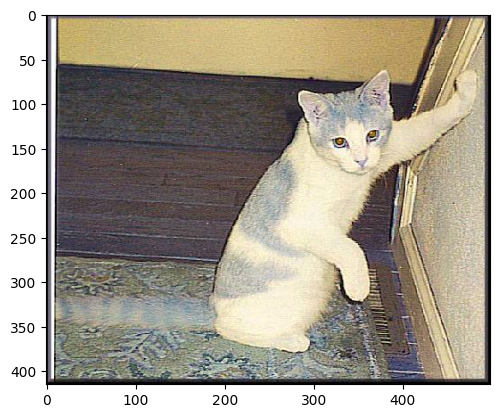

In [104]:
img = cv.imread('/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4001.jpg')
plt.imshow(img)
prediction_class.predict(img)

['dog']

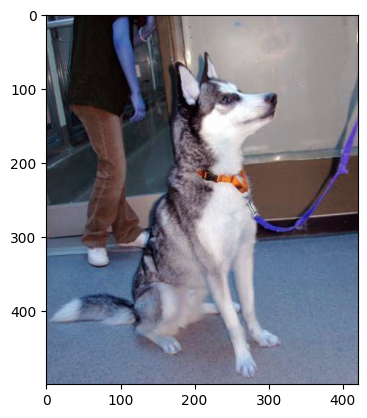

In [105]:
img = cv.imread('/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg')
plt.imshow(img)
prediction_class.predict(img)

# Export model to Onnx

In [123]:
onnx_path = 'onnx_model.onnx'
input_shape = (1,3,224,224)
export_to_ONNX(model, weights = weights, save_path = onnx_path, input_shape = input_shape)

/tmp/ipykernel_32/3390757103.py:26: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  param.requires_grad = not freeze


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [124]:
# kiểm tra cấu trúc và hợp lệ của mô hình ONNX đã được tạo ra bằng cách xuất từ PyTorch
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)


# predict with onnxruntime

['dog']

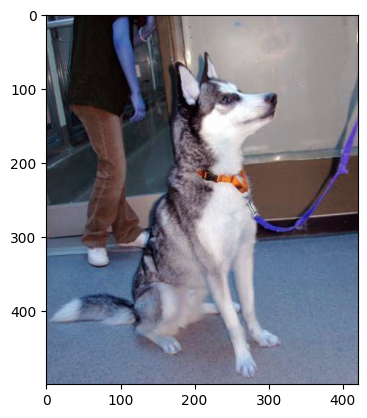

In [166]:
img = cv.imread('/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg')
plt.imshow(img)
onnxruntime_model = onnxruntime.InferenceSession(onnx_path)
predicted_label = predict_onnxruntime(onnxruntime_model, img, label = label)
predicted_label